<a href="https://colab.research.google.com/github/aletcher/impossibility-global-convergence/blob/master/impossibility_global_convergence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Accompanying code for the paper: *On the Impossibility of Global Convergence in Differentiable Games*. Implements a number of multi-loss optimization methods that are shown to enter limit cycles instead of converging in a zero-sum game. This includes (sim)GD, [AGD](https://arxiv.org/pdf/1907.04392.pdf), [EG](https://arxiv.org/pdf/1906.05945.pdf), [OMD](https://arxiv.org/pdf/1711.00141.pdf), [CO](https://arxiv.org/pdf/1705.10461.pdf), [SGA](https://arxiv.org/pdf/1802.05642.pdf), [LA](https://openreview.net/pdf?id=SyGjjsC5tQ), [LOLA](https://arxiv.org/pdf/1709.04326.pdf), [SOS](https://openreview.net/pdf?id=SyGjjsC5tQ), and [CGD](https://arxiv.org/pdf/1905.12103.pdf). The notebook runs in ~5 minutes with GPU accelerator enabled in colab.

In [9]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-darkgrid')

In [10]:
#@markdown Plotting function.
def plot_param(th, algo, start=0):
  fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
  ax = ax.flatten()
  for i, algo in enumerate(algos):
    ax[i].set_xlim(-1.45, 1.45)
    ax[i].set_ylim(-1.45, 1.45)
    ax[i].plot(th_out[i, start:, 0], th_out[i, start:, 1],
               sns.xkcd_rgb["prussian blue"], lw=1.5)
    ax[i].set_title(algo.upper())
    if i < 5:
      ax[i].get_xaxis().set_ticklabels([])
    if not (i == 0 or i == 5 or i == 4 or i == 9):
      ax[i].get_yaxis().set_ticklabels([])
    if i == 4 or i == 9:
      ax[i].yaxis.tick_right()
  plt.show()

In [3]:
#@markdown Gradient computations for each algorithm.

def init_th(dims, std=1):
  th = []
  for i in range(len(dims)):
    if std > 0:
      init = torch.nn.init.normal_(torch.empty(dims[i], requires_grad=True), std=std)
    else:
      init = torch.zeros(dims[i], requires_grad=True)
    th.append(init)
  return th

def get_gradient(function, param):
  try:
    grad = torch.autograd.grad(function, param, create_graph=True)[0]
  except:
    grad = torch.zeros(param.shape)
  return grad

def get_hessian(th, grad_L, diag=True, off_diag=True):
  n = len(th)
  H = []
  for i in range(n):
    row_block = []
    for j in range(n):
      if (i == j and diag) or (i != j and off_diag):
        block = [torch.unsqueeze(get_gradient(grad_L[i][i][k], th[j]), dim=0) 
                  for k in range(len(th[i]))]
        row_block.append(torch.cat(block, dim=0))
      else:
        row_block.append(torch.zeros(len(th[i]), len(th[j])))
    H.append(torch.cat(row_block, dim=1))
  return torch.cat(H, dim=0)

def update_th(th, Ls, alpha, algo, sos_a=0.5, sos_b=0.5, co_gam=0.01, omd_th=None):
  n = len(th)
  losses = Ls(th)

  # Compute gradients
  grad_L = [[get_gradient(losses[j], th[i]) for j in range(n)] for i in range(n)]
  if algo == 'la':
    terms = [sum([torch.dot(grad_L[j][i], grad_L[j][j].detach())
                for j in range(n) if j != i]) for i in range(n)]
    grads = [grad_L[i][i]-alpha*get_gradient(terms[i], th[i]) for i in range(n)]
  elif algo == 'lola':
    terms = [sum([torch.dot(grad_L[j][i], grad_L[j][j])
                for j in range(n) if j != i]) for i in range(n)]
    grads = [grad_L[i][i]-alpha*get_gradient(terms[i], th[i]) for i in range(n)]
  elif algo == 'sos':
    terms = [sum([torch.dot(grad_L[j][i], grad_L[j][j].detach())
                for j in range(n) if j != i]) for i in range(n)]
    xi_0 = [grad_L[i][i]-alpha*get_gradient(terms[i], th[i]) for i in range(n)]
    chi = [get_gradient(sum([torch.dot(grad_L[j][i].detach(), grad_L[j][j])
              for j in range(n) if j != i]), th[i]) for i in range(n)]
    # Compute p
    dot = torch.dot(-alpha*torch.cat(chi), torch.cat(xi_0))
    p1 = 1 if dot >= 0 else min(1, -sos_a*torch.norm(torch.cat(xi_0))**2/dot)
    xi = torch.cat([grad_L[i][i] for i in range(n)])
    xi_norm = torch.norm(xi)
    p2 = xi_norm**2 if xi_norm < sos_b else 1
    p = min(p1, p2)
    grads = [xi_0[i]-p*alpha*chi[i] for i in range(n)]
  elif algo == 'sga':
    xi = torch.cat([grad_L[i][i] for i in range(n)])
    norm = torch.dot(xi, xi.detach())
    H_t_xi = [get_gradient(norm, th[i]) for i in range(n)]
    H_xi = [get_gradient(sum([torch.dot(grad_L[j][i], grad_L[j][j].detach())
              for j in range(n)]), th[i]) for i in range(n)]
    A_t_xi = [H_t_xi[i]/2-H_xi[i]/2 for i in range(n)]
    # Compute lambda (sga with alignment)
    dot_xi = torch.dot(xi, torch.cat(H_t_xi))
    dot_A = torch.dot(torch.cat(A_t_xi), torch.cat(H_t_xi))
    d = sum([len(th[i]) for i in range(n)])
    lam = torch.sign(dot_xi*dot_A/d)
    grads = [grad_L[i][i]+lam*A_t_xi[i] for i in range(n)]
  elif algo == 'co':
    xi = torch.cat([grad_L[i][i] for i in range(n)])
    norm = torch.dot(xi, xi.detach())
    grads = [grad_L[i][i]+co_gam*get_gradient(norm, th[i]) for i in range(n)]
  elif algo == 'eg':
    th_eg = [th[i]-alpha*grad_L[i][i] for i in range(n)]
    losses_eg = Ls(th_eg)
    grads = [get_gradient(losses_eg[i], th_eg[i]) for i in range(n)]
  elif algo == 'agd':
    th_agd = [th[i] for i in range(n)]
    grads = []
    for i in range(n):
      losses_agd = Ls(th_agd)
      grad = get_gradient(losses_agd[i], th_agd[i])
      grads.append(grad)
      th_agd[i] = th_agd[i]-alpha*grad
  elif algo == 'omd':
    past_grad = [get_gradient(Ls(omd_th)[i], omd_th[i]) for i in range(n)]
    grads = [2*grad_L[i][i]-past_grad[i] for i in range(n)]
  elif algo == 'cgd': # Slow implementation (exact matrix inversion)
    dims = [len(th[i]) for i in range(n)]
    xi = torch.cat([grad_L[i][i] for i in range(n)])
    H_o = get_hessian(th, grad_L, diag=False)
    grad = torch.matmul(torch.inverse(torch.eye(sum(dims))+alpha*H_o), xi)
    grads = [grad[sum(dims[:i]):sum(dims[:i+1])] for i in range(n)]
  else: # (simultaneous) GD
    grads = [grad_L[i][i] for i in range(n)]
  
  # Update theta
  past_th = [th[i].clone() for i in range(n)]
  with torch.no_grad():
    for i in range(n):
      th[i] -= alpha*grads[i]
  return th, losses, past_th


In [4]:
#@markdown Game definitions.

def market():
  dims = [1, 1]
  def Ls(th):
    x, y = th
    g = y**4/(1+x**2)-x**4/(1+y**2)
    L_1 = x*y-x**2/2+x**6/6+g/4
    L_2 = -x*y-y**2/2+y**6/6-g/4
    return [L_1, L_2]
  return dims, Ls

def zerosum():
  dims = [1, 1]
  def Ls(th):
    x, y = th
    L_1 = x*y-x**2/2+y**2/2+x**4/4-y**4/4
    return [L_1, -L_1]
  return dims, Ls

def market_with_min(sig=0.01):
  dims = [1, 1]
  def Ls(th):
    x, y = th
    if x**2+y**2 >= sig**2:
      f = (x**2+y**2-sig**2)/2
    else:
      f = (y**2-3*x**2)*(x**2+y**2-sig**2)/(2*sig**2)
    g = y**4/(1+x**2)-x**4/(1+y**2)
    L_1 = x**6/6-x**2+f+x*y+g/4
    L_2 = y**6/6-f-x*y-g/4
    return [L_1, L_2]
  return dims, Ls

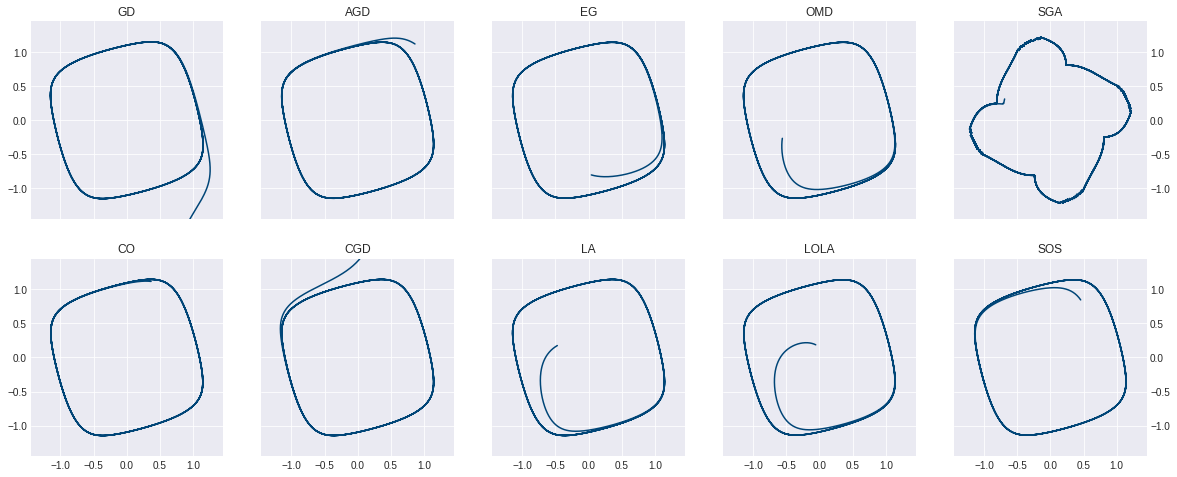

In [11]:
# Run each algorithm on a chosen game (market, zerosum or market_with_min)
dims, Ls = zerosum()
algos = ['gd', 'agd', 'eg', 'omd', 'sga', 'co', 'cgd', 'la', 'lola', 'sos']
alpha = 0.01
num_epochs = 3000

th_out = np.zeros((len(algos), num_epochs, sum(dims)))
for i, algo in enumerate(algos):
  th = init_th(dims, std=1)
  past_th = th.copy()
  losses_out = np.zeros((num_epochs, len(dims)))
  for k in range(num_epochs):
    th_out[i, k] = [theta.clone().data.numpy() for theta in th]
    th, losses, past_th = update_th(th, Ls, alpha, algo, co_gam=0.01, omd_th=past_th)
    losses_out[k] = [loss for loss in losses]

# Plot results from epoch=start onwards (for visual clarity)
plot_param(th_out, algos, start=0)